## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '1d'

perc_inc = 0.02 # 2 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'IYW' # IYW iShares Tech ETF stock

perc_train = 1 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = '10y' # time span of data e.g. 1y or 10y, 2y for 60m, 10y for 1d
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-17,57.060001,57.090000,56.380001,56.930000,51.657349,530800
2010-06-18,57.060001,57.299999,56.799999,56.990002,51.711784,89400
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700


### Assign Descisions for Up %+ or Not

In [5]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [6]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,decision
Date,,,,,,,
2020-05-28,247.910004,253.199997,247.800003,248.570007,248.139145,136300,0
2020-05-29,249.410004,252.710007,247.720001,251.929993,251.493301,101100,0
2020-06-01,251.250000,253.449997,250.500000,253.029999,252.591400,102500,0
2020-06-02,253.270004,255.009995,250.339996,255.009995,254.567963,271300,0
2020-06-03,256.140015,257.619995,255.070007,256.730011,256.285004,185300,0
2020-06-04,256.010010,257.730011,253.139999,254.789993,254.348343,409000,0
2020-06-05,256.140015,261.140015,255.369995,260.130005,259.679108,130300,0
2020-06-08,259.880005,262.380005,257.750000,262.380005,261.925201,147300,0
2020-06-09,261.109985,264.769989,260.649994,263.739990,263.282837,138300,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [7]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [8]:
len(decisions)

2518

In [9]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [10]:
len(decisions)

2517

In [11]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(2517, 7)

In [12]:
stock_df_one_off.iloc[-1]

Open            265.320007
High            265.660004
Low             259.799988
Close           263.739990
Adj Close       263.739990
Volume       127400.000000
decision          0.000000
Name: 2020-06-16 00:00:00, dtype: float64

In [13]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,decision
Date,,,,,,,
2010-06-17,57.060001,57.090000,56.380001,56.930000,51.657349,530800,0
2010-06-18,57.060001,57.299999,56.799999,56.990002,51.711784,89400,0
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700,0
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400,0
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700,0


In [14]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    2463
1      54
Name: decision, dtype: int64

### Balance the 0's and 1's

In [15]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

54

In [16]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [17]:
stock_df_bal.shape

(108, 7)

In [18]:
stock_df_bal.decision.value_counts()

1    54
0    54
Name: decision, dtype: int64

### Train Test Split

In [19]:
X = stock_df_bal.drop(columns=['decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [21]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [22]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.6875000000000001

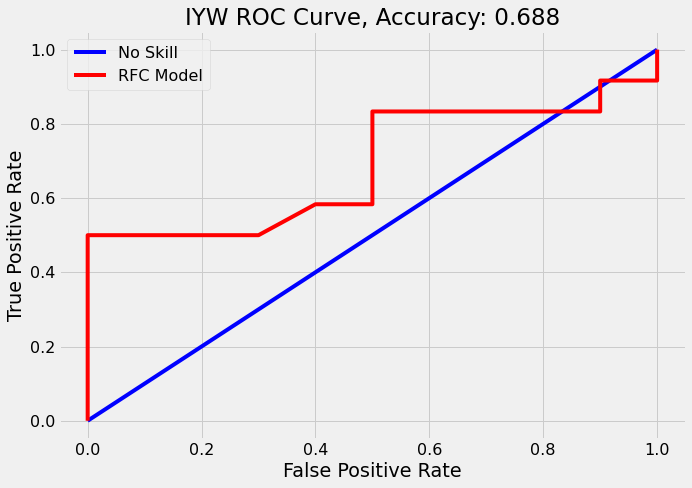

In [23]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:    0.0s finished


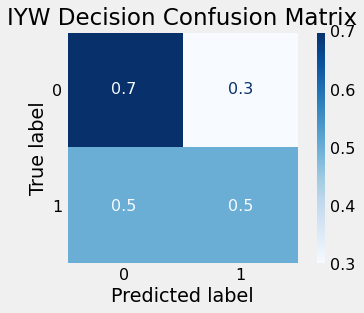

In [24]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

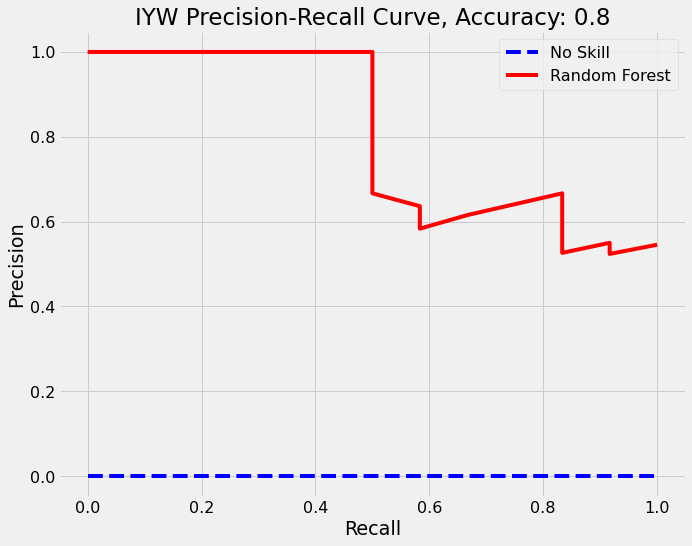

In [25]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [26]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
3,Close,0.184941
0,Open,0.169602
1,High,0.165276
2,Low,0.163284
4,Adj Close,0.159601
5,Volume,0.157294


In [27]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,decision
0,100.389999,101.389999,100.199997,101.389999,96.499336,143100,0
1,68.620003,68.620003,67.849998,67.949997,61.942947,127000,0
2,62.290001,62.509998,62.169998,62.400002,56.762859,147100,0
3,200.970001,201.660004,198.389999,199.820007,197.998108,88600,0
4,174.830002,177.460007,174.789993,177.460007,175.052673,121000,0


### Make A Prediction

In [28]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open           265.429993
High           266.200012
Low            263.515015
Close          265.083405
Adj Close      265.083405
Volume       63749.000000
Name: 2020-06-17 00:00:00, dtype: float64

In [29]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold IYW on the 1d interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:    0.0s finished
